In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

#Genel bilgiler
df = pd.read_excel('/content/TYZ_DataSet.xlsx')

print(df.shape)
display(df.head())
display(df.describe(include='all'))
display(df.info())

(198, 9)


,first_name,last_name,age,Happy_Sad_group,Dosage,Drug,Mem_Score_Before,Mem_Score_After,Diff
0,Bastian,Carrasco,25,H,1,A,635,612,-23
1,Evan,Carrasco,52,S,1,A,416,407,-9
2,Florencia,Carrasco,29,H,1,A,597,551,-46
3,Holly,Carrasco,50,S,1,A,517,512,-5
4,Justin,Carrasco,52,H,1,A,47,471,1


,first_name,last_name,age,Happy_Sad_group,Dosage,Drug,Mem_Score_Before,Mem_Score_After,Diff
count,198,198,198.000000,198,198.000000,198,198.000000,198.000000,198.000000
unique,139,18,NaN,2,NaN,3,NaN,NaN,NaN
top,Jun,Durand,NaN,H,NaN,A,NaN,NaN,NaN
freq,5,44,NaN,99,NaN,67,NaN,NaN,NaN
mean,NaN,NaN,39.530303,NaN,1.989899,NaN,481.222222,507.131313,20.136364
std,NaN,NaN,12.023099,NaN,0.818504,NaN,225.225845,225.526058,94.566693
min,NaN,NaN,24.000000,NaN,1.000000,NaN,36.000000,39.000000,-404.000000
25%,NaN,NaN,30.000000,NaN,1.000000,NaN,409.750000,417.250000,-27.500000
50%,NaN,NaN,37.000000,NaN,2.000000,NaN,514.500000,527.000000,5.000000
75%,NaN,NaN,48.000000,NaN,3.000000,NaN,617.500000,657.500000,51.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   first_name        198 non-null    object
 1   last_name         198 non-null    object
 2   age               198 non-null    int64 
 3   Happy_Sad_group   198 non-null    object
 4   Dosage            198 non-null    int64 
 5   Drug              198 non-null    object
 6   Mem_Score_Before  198 non-null    int64 
 7   Mem_Score_After   198 non-null    int64 
 8   Diff              198 non-null    int64 
dtypes: int64(5), object(4)
memory usage: 14.1+ KB


None

In [4]:
#Eksik değer analizi
missing = df.isnull().sum().sort_values(ascending=False)
missing_pct = (df.isnull().mean()*100).sort_values(ascending=False)
pd.concat([missing, missing_pct], axis=1, keys=['missing_count','missing_pct']).head(30)

,missing_count,missing_pct
first_name,0,0.0
last_name,0,0.0
age,0,0.0
Happy_Sad_group,0,0.0
Dosage,0,0.0
Drug,0,0.0
Mem_Score_Before,0,0.0
Mem_Score_After,0,0.0
Diff,0,0.0


In [5]:
#Tekrarlayan gözlem ve veri dağılımı
for c in df.columns:
    nunique = df[c].nunique()
    if nunique < 20:
        print(c, 'unique:', nunique, '->', df[c].value_counts().head())

last_name unique: 18 -> last_name
Durand       44
Carrasco     43
Lopez        23
Takahashi    20
Summers      12
Name: count, dtype: int64
Happy_Sad_group unique: 2 -> Happy_Sad_group
H    99
S    99
Name: count, dtype: int64
Dosage unique: 3 -> Dosage
1    67
2    66
3    65
Name: count, dtype: int64
Drug unique: 3 -> Drug
A    67
S    66
T    65
Name: count, dtype: int64


In [6]:
#Uç değer tespiti (IQR yöntemi) - sayısal kolonlara uygulandı
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
outliers = {}
for c in num_cols:
    q1 = df[c].quantile(0.25)
    q3 = df[c].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    mask = (df[c] < low) | (df[c] > high)
    outliers[c] = mask.sum()
pd.Series(outliers).sort_values(ascending=False).head(20)

,0
Mem_Score_Before,31
Diff,23
Mem_Score_After,9
age,2
Dosage,0


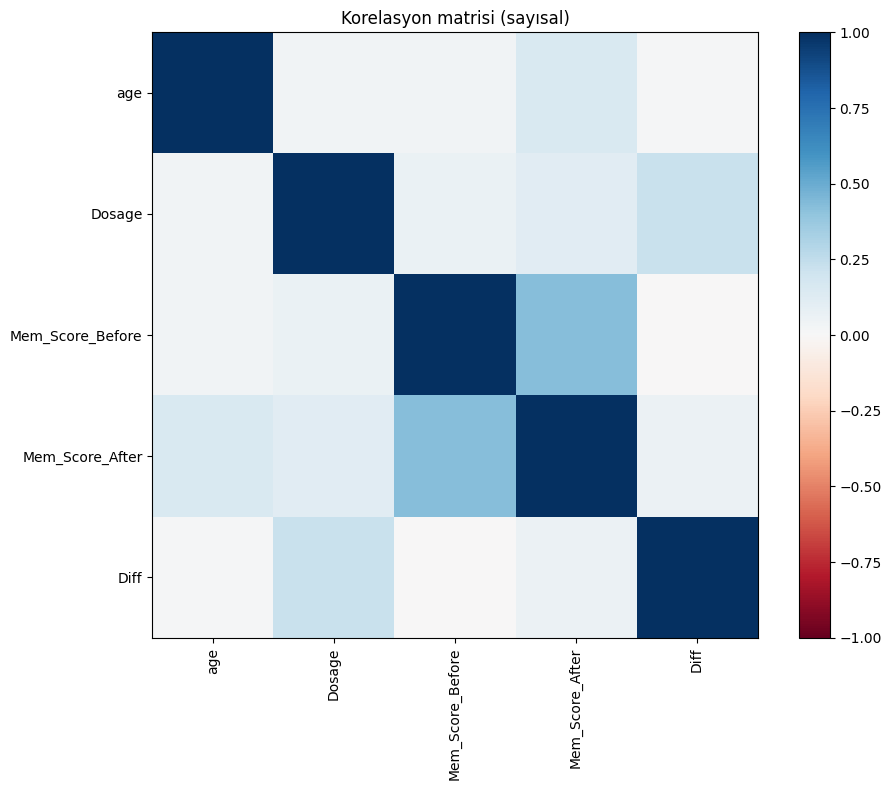

In [7]:
#Korelasyon matrisi (sayısal sütunlar için)
corr = df[num_cols].corr()
plt.figure(figsize=(10,8))
plt.title('Korelasyon matrisi (sayısal)')
plt.imshow(corr, interpolation='nearest', cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.tight_layout()
plt.show()

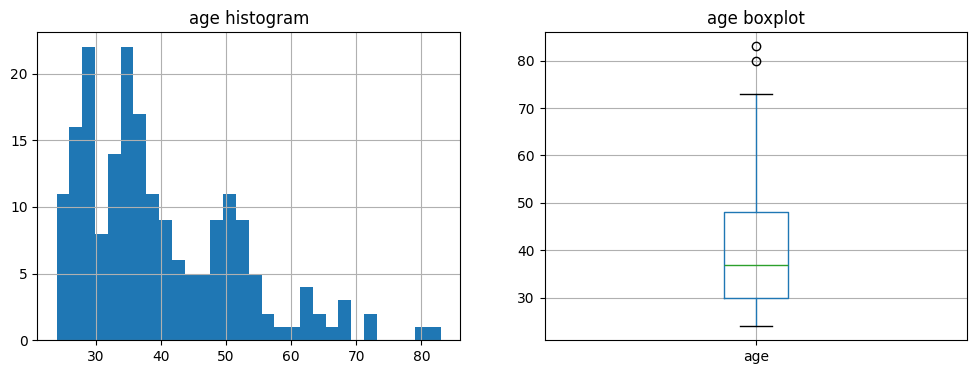

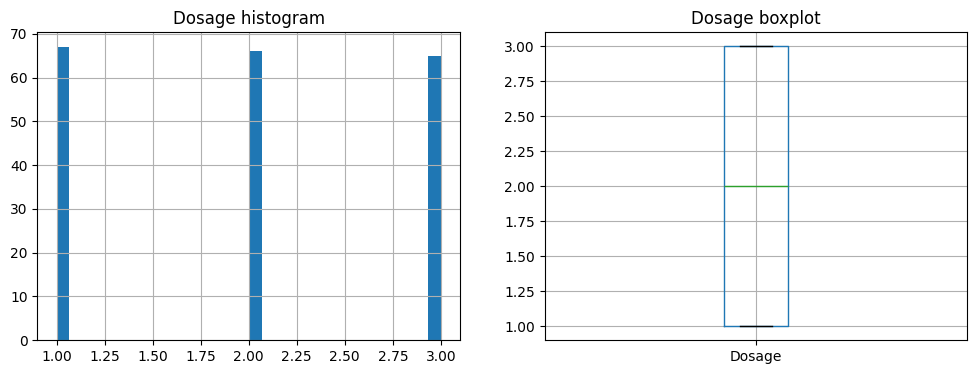

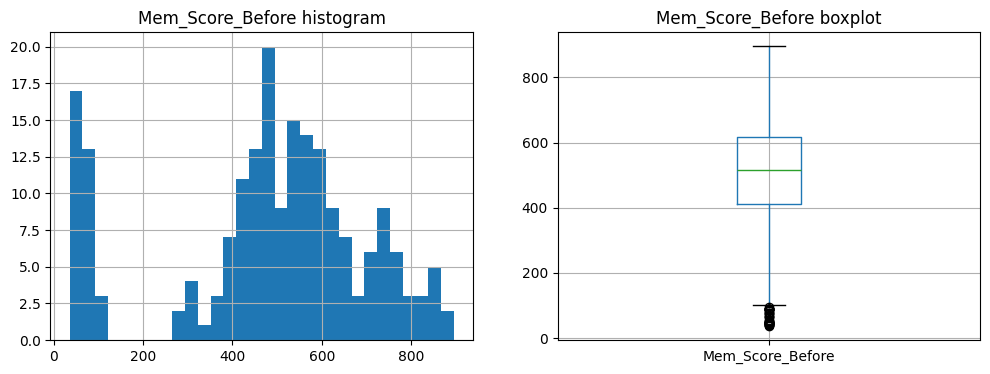

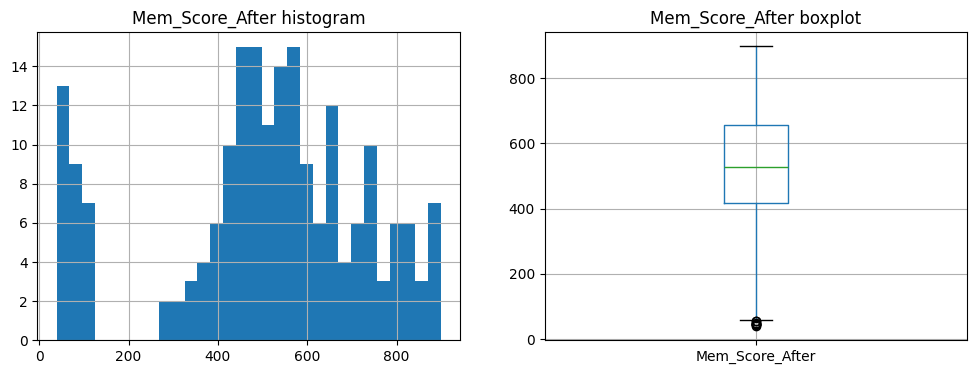

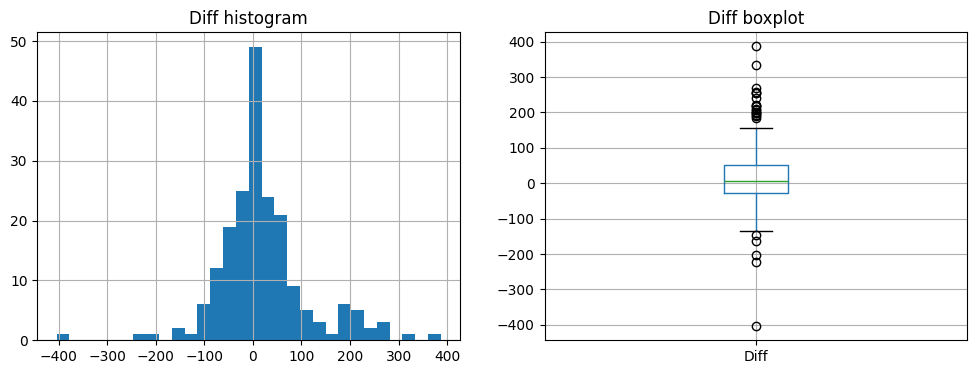

In [8]:
#Veri seti dağılımını gözlemlemek için histogram ve boxplot
for c in num_cols:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    df[c].hist(bins=30)
    plt.title(f'{c} histogram')
    plt.subplot(1,2,2)
    df.boxplot(column=c)
    plt.title(f'{c} boxplot')
    plt.show()

In [9]:
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import RobustScaler

#ID sütunu ekleyip ve isimleri çıkarma
df['PatientID'] = range(1, len(df) + 1)
df = df.drop(columns=['first_name', 'last_name'])

#Kategorik ve numerik sütunları ayırma
categorical_cols = ['Happy_Sad_group', 'Drug']
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['PatientID']]  # ID scaler’dan hariç

#Winsorize
for col in numeric_cols:
    df[col] = winsorize(df[col], limits=[0.05, 0.05])

#RobustScaler
scaler = RobustScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

#Kategorik verileri sayısal değerlere dönüştürme

#Happy_Sad_group: H -> 1, S -> 0
df['Happy_Sad_group'] = df['Happy_Sad_group'].map({'H': 1, 'S': 0})

#Drug: A -> 0, S -> 1, T -> 2
df['Drug'] = df['Drug'].map({'A': 0, 'S': 1, 'T': 2})

print(df.head())


        age  Happy_Sad_group  Dosage  Drug  Mem_Score_Before  Mem_Score_After  \
0 -0.666667                1    -0.5     0          0.580024         0.353798   
1  0.833333                0    -0.5     0         -0.474128        -0.499480   
2 -0.444444                1    -0.5     0          0.397112         0.099896   
3  0.722222                0    -0.5     0          0.012034        -0.062435   
4  0.833333                1    -0.5     0         -2.250301        -0.233091   

       Diff  PatientID  
0 -0.356688          1  
1 -0.178344          2  
2 -0.649682          3  
3 -0.127389          4  
4 -0.050955          5  


In [67]:
!pip install -q gymnasium torch numpy pandas
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import gymnasium as gym


# Dinamik Model
# Input: [Diff, Dosage, Drug, Group, Action]
# Output: Tahmin edilen yeni Diff
class DynamicsModel(nn.Module):
    def __init__(self):
        super(DynamicsModel, self).__init__()
        self.fc1 = nn.Linear(5, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)  #Yeni Diff tahmini

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

#Model oluşturma
dynamics_model = DynamicsModel()

#Optimizasyon
dyn_optimizer = optim.Adam(dynamics_model.parameters(), lr=0.001)

#Environment
class MedicalEnv(gym.Env):
    def __init__(self, df):
        super(MedicalEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.current_idx = 0
        self.episode_order = list(range(len(self.df)))
        self.prediction_errors = []


        #Eylem uzayı: 0 -> azalt, 1 -> sabit tut, 2 -> artır
        self.action_space = gym.spaces.Discrete(3)

        #Durum uzayı: Diff, Dosage, Drug, Happy_Sad_group
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf, shape=(4,), dtype=np.float32
        )

    #Yeni oyuna başla, başlangıç durumunu ver
    def reset(self, seed=None, options=None):
        self.current_idx = 0
        np.random.shuffle(self.episode_order)
        state = self._get_state(self.df.iloc[self.episode_order[self.current_idx]])
        return state, {}

    #Ajan bir adım attı, bunun sonucunda çevrede olan
    def step(self, action):
        row = self.df.iloc[self.episode_order[self.current_idx]]
        diff = row['Diff']
        dosage = row['Dosage']
        group = row['Happy_Sad_group']
        drug = float(row['Drug'])

        #Diff değişimi dinamik modelden tahmin ediliyor
        dyn_input = torch.FloatTensor([diff, dosage, drug, group, action])
        predicted_next_diff = dynamics_model(dyn_input).item()

        #Kurulan reward mantığı
        reward = 0
        if group == 1:  #Happy
            if dosage == -0.5 and action == 1:  #sabit
                reward = 1.0
            elif dosage in [0, 0.5] and action == 0:  #azalt

                reward = 1.0
            else:
                reward = -1.0
        else:  #Sad
            if dosage == 0.5 and action == 1:  #sabit
                reward = 1.0
            elif dosage in [-0.5, 0] and action == 2: #artır
                reward = 1.0
            else:
                reward = -1.0

        #Env’ın adım adım ilerlemesini ve hangi state’in bir sonraki adım olacağının kontrolü
        self.current_idx += 1
        terminated = self.current_idx >= len(self.df)
        truncated = False

        if not terminated:
            next_row = self.df.iloc[self.episode_order[self.current_idx]]

            #State model tarafından kontrol ediliyor
            next_state = np.array([
                predicted_next_diff, #Modelin tahmini
                next_row["Dosage"],
                float(next_row["Drug"]),
                float(next_row["Happy_Sad_group"])
            ], dtype=np.float32)

            #Tahmin hatasını kaydetme
            true_next_diff = next_row["Diff"]
            error = predicted_next_diff - true_next_diff
            self.prediction_errors.append(error)

        else:
            next_state = np.zeros(4, dtype=np.float32)

        return next_state, reward, terminated, truncated, {}

    def _get_state(self, row):
        return np.array([
            row['Diff'],
            row['Dosage'],
            float(row['Drug']),
            float(row['Happy_Sad_group'])
        ], dtype=np.float32)

#Policy Network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.softmax(x, dim=-1)


#Reinforce algoritması
def train_reinforce(env, policy_net, optimizer, num_episodes=800, gamma=0.99):
    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        rewards = []
        log_probs = []
        done = False

        #Ajan adım adım hareket ediyor, ödül topluyor ve öğrenme için gerekli verileri kaydediyor
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            probs = policy_net(state_tensor)
            m = Categorical(probs)
            action = m.sample()
            log_prob = m.log_prob(action)

            next_state, reward, terminated, truncated, _ = env.step(action.item())
            log_probs.append(log_prob)
            rewards.append(reward)
            state = next_state
            done = terminated or truncated

        #Return hesaplama
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        optimizer.zero_grad()
        loss = 0
        for log_prob, R in zip(log_probs, returns):
            loss -= log_prob * R
        loss.backward()
        optimizer.step()

        if episode % 50 == 0:
            print(f"Episode {episode}/{num_episodes}, total reward: {sum(rewards):.2f}")

# Env + Policy
state_dim = 4
action_dim = 3
policy_net = PolicyNetwork(state_dim, action_dim)
optimizer = optim.Adam(policy_net.parameters(), lr=0.01)

env = MedicalEnv(df)

#Eğitim
train_reinforce(env, policy_net, optimizer, num_episodes=800)

#Test
# Çoklu-epizot testi (100 epizot)
num_test_episodes = 100
total_rewards = []
total_balance_times = []   # her epizodda kaç adım "denge" (ödül>0) oldu

for _ in range(num_test_episodes):
    state, _ = env.reset()
    done = False
    ep_reward = 0.0
    ep_balance_steps = 0
    while not done:
        #Deterministik seçim (testte argmax kullanıyorum)
        probs = policy_net(torch.FloatTensor(state).unsqueeze(0))
        action = torch.argmax(probs).item()
        next_state, reward, terminated, truncated, _ = env.step(action)
        state = next_state
        done = terminated or truncated
        ep_reward += reward
        if reward > 0:    # ödül pozitifse adımı "doğru/denge" olarak saydırma
            ep_balance_steps += 1

    total_rewards.append(ep_reward)
    total_balance_times.append(ep_balance_steps)

average_reward = np.mean(total_rewards)
average_balance_time = np.mean(total_balance_times)

print(f"{num_test_episodes} epizot için ortalama test ödül: {average_reward:.2f}")
print(f"{num_test_episodes} epizot için ortalama denge süresi: {average_balance_time:.2f}")

#Tek epizot accuracy
state, _ = env.reset()
done = False
ep_reward = 0.0
correct_steps = 0
total_steps = 0

while not done:
    probs = policy_net(torch.FloatTensor(state).unsqueeze(0))
    action = torch.argmax(probs).item()
    next_state, reward, terminated, truncated, _ = env.step(action)
    state = next_state
    done = terminated or truncated

    ep_reward += reward
    total_steps += 1
    if reward > 0:  #reward >0 kriterine göre "doğru" karar
        correct_steps += 1

accuracy = correct_steps / total_steps if total_steps > 0 else 0.0
print("\n--- Tek-run sonuçları ---")
print(f"Toplam ödül: {ep_reward:.2f}")
print(f"Accuracy = {accuracy:.2%}")

#Dynamics model tahmin hatalarının özeti
errors = np.array(env.prediction_errors)
print("\n--- Dynamics Model Tahmin Hatası ---")
print(f"Ortalama hata: {errors.mean():.4f}")
print(f"Standart sapma: {errors.std():.4f}")


Episode 50/800, total reward: 20.00
Episode 100/800, total reward: 70.00
Episode 150/800, total reward: 54.00
Episode 200/800, total reward: 68.00
Episode 250/800, total reward: 68.00
Episode 300/800, total reward: 68.00
Episode 350/800, total reward: 68.00
Episode 400/800, total reward: 68.00
Episode 450/800, total reward: 68.00
Episode 500/800, total reward: 68.00
Episode 550/800, total reward: 68.00
Episode 600/800, total reward: 68.00
Episode 650/800, total reward: 16.00
Episode 700/800, total reward: 68.00
Episode 750/800, total reward: 72.00
Episode 800/800, total reward: 68.00
100 epizot için ortalama test ödül: 67.96
100 epizot için ortalama denge süresi: 132.98

--- Tek-run sonuçları ---
Toplam ödül: 68.00
Accuracy = 67.17%

--- Dynamics Model Tahmin Hatası ---
Ortalama hata: -0.3578
Standart sapma: 1.0004


In [10]:
#Optimizasyon
# Dinamik Model
# Input: [Diff, Dosage, Drug, Group, Action]
# Output: Tahmin edilen yeni Diff
class DynamicsModel(nn.Module):
    def __init__(self):
        super(DynamicsModel, self).__init__()
        self.fc1 = nn.Linear(5, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)  #Yeni Diff tahmini

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

#Model oluşturma
dynamics_model = DynamicsModel()

#Optimizasyon
dyn_optimizer = optim.Adam(dynamics_model.parameters(), lr=0.001)

#Environment
class MedicalEnv(gym.Env):
    def __init__(self, df):
        super(MedicalEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.current_idx = 0
        self.episode_order = list(range(len(self.df)))
        self.prediction_errors = []

        #Eylem uzayı: 0 -> azalt, 1 -> sabit tut, 2 -> artır
        self.action_space = gym.spaces.Discrete(3)

        #Durum uzayı: Diff, Dosage, Drug, Happy_Sad_group
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf, shape=(4,), dtype=np.float32
        )

    #Yeni oyuna başla, başlangıç durumunu ver
    def reset(self, seed=None, options=None):
        self.current_idx = 0
        np.random.shuffle(self.episode_order)
        state = self._get_state(self.df.iloc[self.episode_order[self.current_idx]])
        return state, {}

    #Ajan bir adım attı, bunun sonucunda çevrede olan
    def step(self, action):
        row = self.df.iloc[self.episode_order[self.current_idx]]
        diff = row['Diff']
        dosage = row['Dosage']
        group = row['Happy_Sad_group']
        drug = float(row['Drug'])

        #Diff değişimi dinamik modelden tahmin ediliyor
        dyn_input = torch.FloatTensor([diff, dosage, drug, group, action])
        predicted_next_diff = dynamics_model(dyn_input).item()

        #Kurulan reward mantığı
        reward = 0
        if group == 1:  #Happy
            if dosage == -0.5 and action == 1:  #sabit
                reward = 1.0
            elif dosage in [0, 0.5] and action == 0:  #azalt

                reward = 1.0
            else:
                reward = -1.0
        else:  #Sad
            if dosage == 0.5 and action == 1:  #sabit
                reward = 1.0
            elif dosage in [-0.5, 0] and action == 2: #artır
                reward = 1.0
            else:
                reward = -1.0

        #Env’ın adım adım ilerlemesini ve hangi state’in bir sonraki adım olacağının kontrolü
        self.current_idx += 1
        terminated = self.current_idx >= len(self.df)
        truncated = False

        if not terminated:
            next_row = self.df.iloc[self.episode_order[self.current_idx]]

            #State model tarafından kontrol ediliyor
            next_state = np.array([
                predicted_next_diff, #Modelin tahmini
                next_row["Dosage"],
                float(next_row["Drug"]),
                float(next_row["Happy_Sad_group"])
            ], dtype=np.float32)

            #Tahmin hatasını kaydetme
            true_next_diff = next_row["Diff"]
            error = predicted_next_diff - true_next_diff
            self.prediction_errors.append(error)

        else:
            next_state = np.zeros(4, dtype=np.float32)

        return next_state, reward, terminated, truncated, {}

    def _get_state(self, row):
        return np.array([
            row['Diff'],
            row['Dosage'],
            float(row['Drug']),
            float(row['Happy_Sad_group'])
        ], dtype=np.float32)

#Policy Network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.softmax(x, dim=-1)


#Reinforce algoritması
def train_reinforce(env, policy_net, optimizer, num_episodes=1150, gamma=0.99, decay=0.999): #Stabil öğrenme
    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        rewards = []
        log_probs = []
        done = False

        #Ajan adım adım hareket ediyor, ödül topluyor ve öğrenme için gerekli verileri kaydediyor
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            probs = policy_net(state_tensor)
            m = Categorical(probs)
            action = m.sample()
            log_prob = m.log_prob(action)

            next_state, reward, terminated, truncated, _ = env.step(action.item())
            log_probs.append(log_prob)
            rewards.append(reward)
            state = next_state
            done = terminated or truncated

        #Return hesaplama
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        optimizer.zero_grad()
        loss = 0
        for log_prob, R in zip(log_probs, returns):
            loss -= log_prob * R
        loss.backward()
        optimizer.step()

        if episode % 50 == 0:
            print(f"Episode {episode}/{num_episodes}, total reward: {sum(rewards):.2f}")

# Env + Policy
state_dim = 4
action_dim = 3
policy_net = PolicyNetwork(state_dim, action_dim)
optimizer = optim.Adam(policy_net.parameters(), lr=0.005)

env = MedicalEnv(df)

#Eğitim
train_reinforce(env, policy_net, optimizer, num_episodes=1150)

#Test
# Çoklu-epizot testi (100 epizot)
num_test_episodes = 100
total_rewards = []
total_balance_times = []   # her epizodda kaç adım "denge" (ödül>0) oldu

for _ in range(num_test_episodes):
    state, _ = env.reset()
    done = False
    ep_reward = 0.0
    ep_balance_steps = 0
    while not done:
        #Deterministik seçim (testte argmax kullanıyorum)
        probs = policy_net(torch.FloatTensor(state).unsqueeze(0))
        action = torch.argmax(probs).item()
        next_state, reward, terminated, truncated, _ = env.step(action)
        state = next_state
        done = terminated or truncated
        ep_reward += reward
        if reward > 0:    # ödül pozitifse adımı "doğru/denge" olarak saydırma
            ep_balance_steps += 1

    total_rewards.append(ep_reward)
    total_balance_times.append(ep_balance_steps)

average_reward = np.mean(total_rewards)
average_balance_time = np.mean(total_balance_times)

print(f"{num_test_episodes} epizot için ortalama test ödül: {average_reward:.2f}")
print(f"{num_test_episodes} epizot için ortalama denge süresi: {average_balance_time:.2f}")

#Tek epizot accuracy
state, _ = env.reset()
done = False
ep_reward = 0.0
correct_steps = 0
total_steps = 0

while not done:
    probs = policy_net(torch.FloatTensor(state).unsqueeze(0))
    action = torch.argmax(probs).item()
    next_state, reward, terminated, truncated, _ = env.step(action)
    state = next_state
    done = terminated or truncated

    ep_reward += reward
    total_steps += 1
    if reward > 0:  #reward >0 kriterine göre "doğru" karar
        correct_steps += 1

accuracy = correct_steps / total_steps if total_steps > 0 else 0.0
print("\n--- Tek-run sonuçları ---")
print(f"Toplam ödül: {ep_reward:.2f}")
print(f"Accuracy = {accuracy:.2%}")

#Dynamics model tahmin hatalarının özeti
errors = np.array(env.prediction_errors)
print("\n--- Dynamics Model Tahmin Hatası ---")
print(f"Ortalama hata: {errors.mean():.4f}")
print(f"Standart sapma: {errors.std():.4f}")


Episode 50/1150, total reward: 46.00
Episode 100/1150, total reward: 74.00
Episode 150/1150, total reward: 80.00
Episode 200/1150, total reward: 74.00
Episode 250/1150, total reward: 76.00
Episode 300/1150, total reward: 64.00
Episode 350/1150, total reward: 96.00
Episode 400/1150, total reward: 58.00
Episode 450/1150, total reward: 84.00
Episode 500/1150, total reward: 82.00
Episode 550/1150, total reward: 124.00
Episode 600/1150, total reward: 102.00
Episode 650/1150, total reward: 84.00
Episode 700/1150, total reward: 138.00
Episode 750/1150, total reward: 140.00
Episode 800/1150, total reward: 96.00
Episode 850/1150, total reward: 132.00
Episode 900/1150, total reward: 130.00
Episode 950/1150, total reward: 130.00
Episode 1000/1150, total reward: 120.00
Episode 1050/1150, total reward: 130.00
Episode 1100/1150, total reward: 134.00
Episode 1150/1150, total reward: 134.00
100 epizot için ortalama test ödül: 134.00
100 epizot için ortalama denge süresi: 166.00

--- Tek-run sonuçları 

In [11]:
#Modelin doğru ve yanlış karar verdiği satırların ID’lerini gösterimi
rewarded_ids = []
punished_ids = []

num_test_episodes = 100

for _ in range(num_test_episodes):
    state, _ = env.reset()
    done = False

    while not done:
        #Aksiyon seçimi
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        probs = policy_net(state_tensor)
        action = torch.argmax(probs).item()

        #O anki satırın ID'sini alma
        current_row_id = env.episode_order[env.current_idx]

        #Ortamda adım atma
        next_state, reward, terminated, truncated, _ = env.step(action)
        state = next_state
        done = terminated or truncated

        #Ödüle göre ID kaydetme
        if reward > 0:
            rewarded_ids.append(current_row_id)
        else:
            punished_ids.append(current_row_id)

print("Pozitif ödül alan ilk 5 ID:", rewarded_ids[:5])
print("Negatif/0 ödül alan ilk 5 ID:", punished_ids[:5])


Pozitif ödül alan ilk 5 ID: [2, 37, 158, 48, 9]
Negatif/0 ödül alan ilk 5 ID: [111, 57, 56, 126, 189]


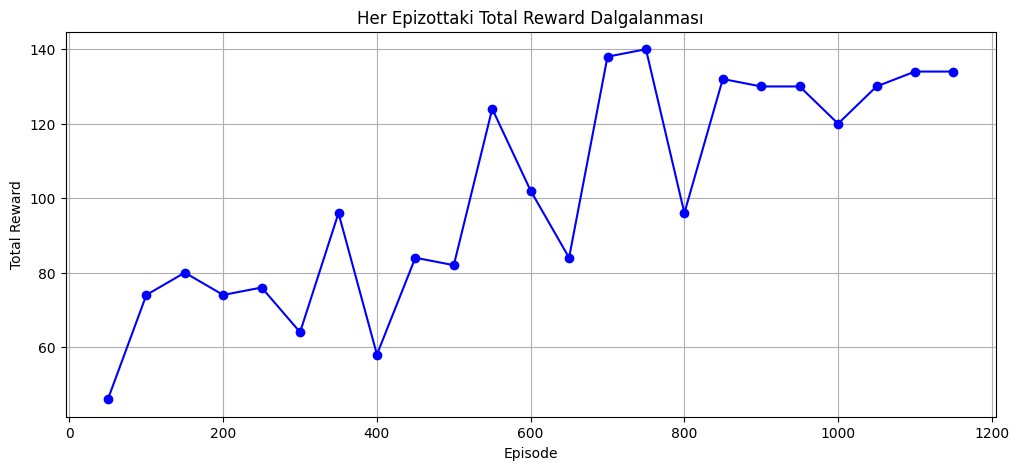

In [14]:
#Eğitim sırasında episode'lardaki dalgalanmayı gösteren görsel
import re

# Eğitim sırasında konsola yazdırılan loglar
log_output = """
Episode 50/1150, total reward: 46.00
Episode 100/1150, total reward: 74.00
Episode 150/1150, total reward: 80.00
Episode 200/1150, total reward: 74.00
Episode 250/1150, total reward: 76.00
Episode 300/1150, total reward: 64.00
Episode 350/1150, total reward: 96.00
Episode 400/1150, total reward: 58.00
Episode 450/1150, total reward: 84.00
Episode 500/1150, total reward: 82.00
Episode 550/1150, total reward: 124.00
Episode 600/1150, total reward: 102.00
Episode 650/1150, total reward: 84.00
Episode 700/1150, total reward: 138.00
Episode 750/1150, total reward: 140.00
Episode 800/1150, total reward: 96.00
Episode 850/1150, total reward: 132.00
Episode 900/1150, total reward: 130.00
Episode 950/1150, total reward: 130.00
Episode 1000/1150, total reward: 120.00
Episode 1050/1150, total reward: 130.00
Episode 1100/1150, total reward: 134.00
Episode 1150/1150, total reward: 134.00
"""

# Episode ve reward değerlerinin çekilmesi
episodes = [int(x) for x in re.findall(r"Episode (\d+)", log_output)]
rewards = [float(x) for x in re.findall(r"total reward: ([\-\d\.]+)", log_output)]

# Çizgi grafiği
plt.figure(figsize=(12,5))
plt.plot(episodes, rewards, marker='o', linestyle='-', color='blue')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Her Epizottaki Total Reward Dalgalanması")
plt.grid(True)
plt.show()
